importing necessary libraries

In [2]:
## Data loading, processing 
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

## Visualization
import seaborn as sb
import matplotlib.pyplot as plt


In the first row we can see 9 features and a target column.

The feature columms are :

Step: This feature represents the day from the start of simulation. It has 180 steps so simulation ran for virtually 6 months.

Customer: represents the customer id

zipCodeOrigin: The zip code of origin/source.

Merchant: The merchant's id

zipMerchant: The merchant's zip code

Age: Categorized age
0: <= 18,
1: 19-25,
2: 26-35,
3: 36-45,
4: 46:55,
5: 56:65,
6: > 65
U: Unknown

Gender: Gender for customer

E : Enterprise,
M: Male,
F: Female,
U: Unknown

Category: Category of the purchase.

Amount: Amount of the purchase

Fraud: Target which shows if the transaction fraudulent(1) or benign(0)

In [3]:
# read the dataset and show the first 10 rows
data = pd.read_csv("data/bs140513_032310.csv")
df = pd.DataFrame(data)
data.head(10)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0
5,0,'C1315400589','3','F','28007','M348934600','28007','es_transportation',25.81,0
6,0,'C765155274','1','F','28007','M348934600','28007','es_transportation',9.10,0
7,0,'C202531238','4','F','28007','M348934600','28007','es_transportation',21.17,0
8,0,'C105845174','3','M','28007','M348934600','28007','es_transportation',32.40,0
9,0,'C39858251','5','F','28007','M348934600','28007','es_transportation',35.40,0


The information about the data
Because it's columns are non-null we don't expect null values in the dataset.

In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


Fraud data is often imbalanced, as shown in the plot and the instance counts.

To balance the dataset, we can use oversampling or undersampling techniques. 

Oversampling involves increasing the number of instances in the minority class by generating new instances, while undersampling reduces the number of instances in the majority class by randomly selecting points until it matches the minority class. 

Both methods have their risks: 

oversampling can create duplicate or similar data points, which may not be effective for fraud detection due to the variability in fraudulent transactions, and undersampling can lead to loss of data and information. 

We will use an oversampling technique called SMOTE (Synthetic Minority Over-sampling Technique), which generates new data points for the minority class using neighboring instances, ensuring the new samples are not exact copies but are similar to the existing ones.

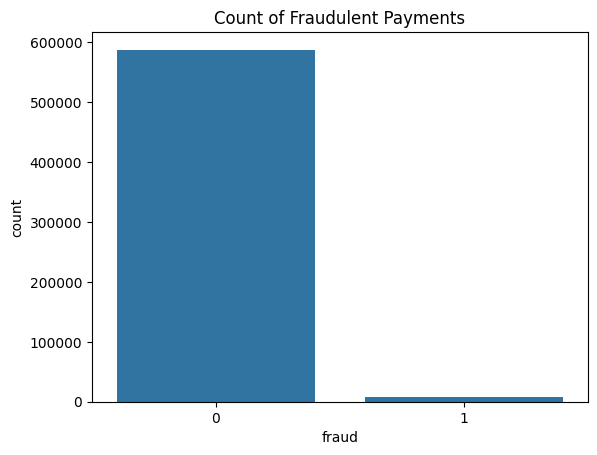

# normal examples:  587443
# fradulent examples:  7200


In [5]:
# 2 dataframes for fraud and non-fraud data 
df_nfraud = data.loc[data.fraud == 0]
df_fraud = data.loc[data.fraud == 1] 


sb.countplot(x="fraud",data=data)
plt.title("Count of Fraudulent Payments")
plt.show()
print("# normal examples: ",df_nfraud.fraud.count())
print("# fradulent examples: ",df_fraud.fraud.count())



 you can see the mean of amount of purchases and number of fraud payments in each category.
 It appears that leisure and travel are the top categories targeted by fraudsters. 
 
  Fraudsters seem to prefer categories where average spending is higher. To validate this hypothesis, let's examine the transaction amounts for both fraud and non-fraud transactions.

In [6]:

# Group by 'category' and aggregate 'amount', 'fraud', and count the number of transactions
grouped_df = df.groupby('category').agg(
    mean_amount=('amount', 'mean'),
    sum_fraud=('fraud', 'sum'),
    total_transactions=('step', 'count')
)
print(grouped_df)



                         mean_amount  sum_fraud  total_transactions
category                                                           
'es_barsandrestaurants'    43.461014        120                6373
'es_contents'              44.547571          0                 885
'es_fashion'               65.666642        116                6454
'es_food'                  37.070405          0               26254
'es_health'               135.621367       1696               16133
'es_home'                 165.670846        302                1986
'es_hotelservices'        205.614249        548                1744
'es_hyper'                 45.970421        280                6098
'es_leisure'              288.911303        474                 499
'es_otherservices'        135.881524        228                 912
'es_sportsandtoys'        215.715280       1982                4002
'es_tech'                 120.947937        158                2370
'es_transportation'        26.958187          0 

we can see the pecentage of fraudulant transactions in each category in the below table.

In [7]:
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_nfraud.groupby('category')['amount'].mean(),\
           data.groupby('category')['fraud'].mean()*100],keys=["Fraud","Non-Fraud","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Percent(%)'], ascending= False)

,Fraud,Non-Fraud,Percent(%)
category,,,
'es_leisure',300.286878,73.230400,94.989980
'es_travel',2660.802872,669.025533,79.395604
'es_sportsandtoys',345.366811,88.502738,49.525237
'es_hotelservices',421.823339,106.548545,31.422018
'es_otherservices',316.469605,75.685497,25.000000
'es_home',457.484834,113.338409,15.206445
'es_health',407.031338,103.737228,10.512614
'es_tech',415.274114,99.924638,6.666667
'es_wellnessandbeauty',229.422535,57.320219,4.759380


 in all the categories the average amount spend are similat; it's between 0-500 discarding the outliers, except for the travel category that average is very high.



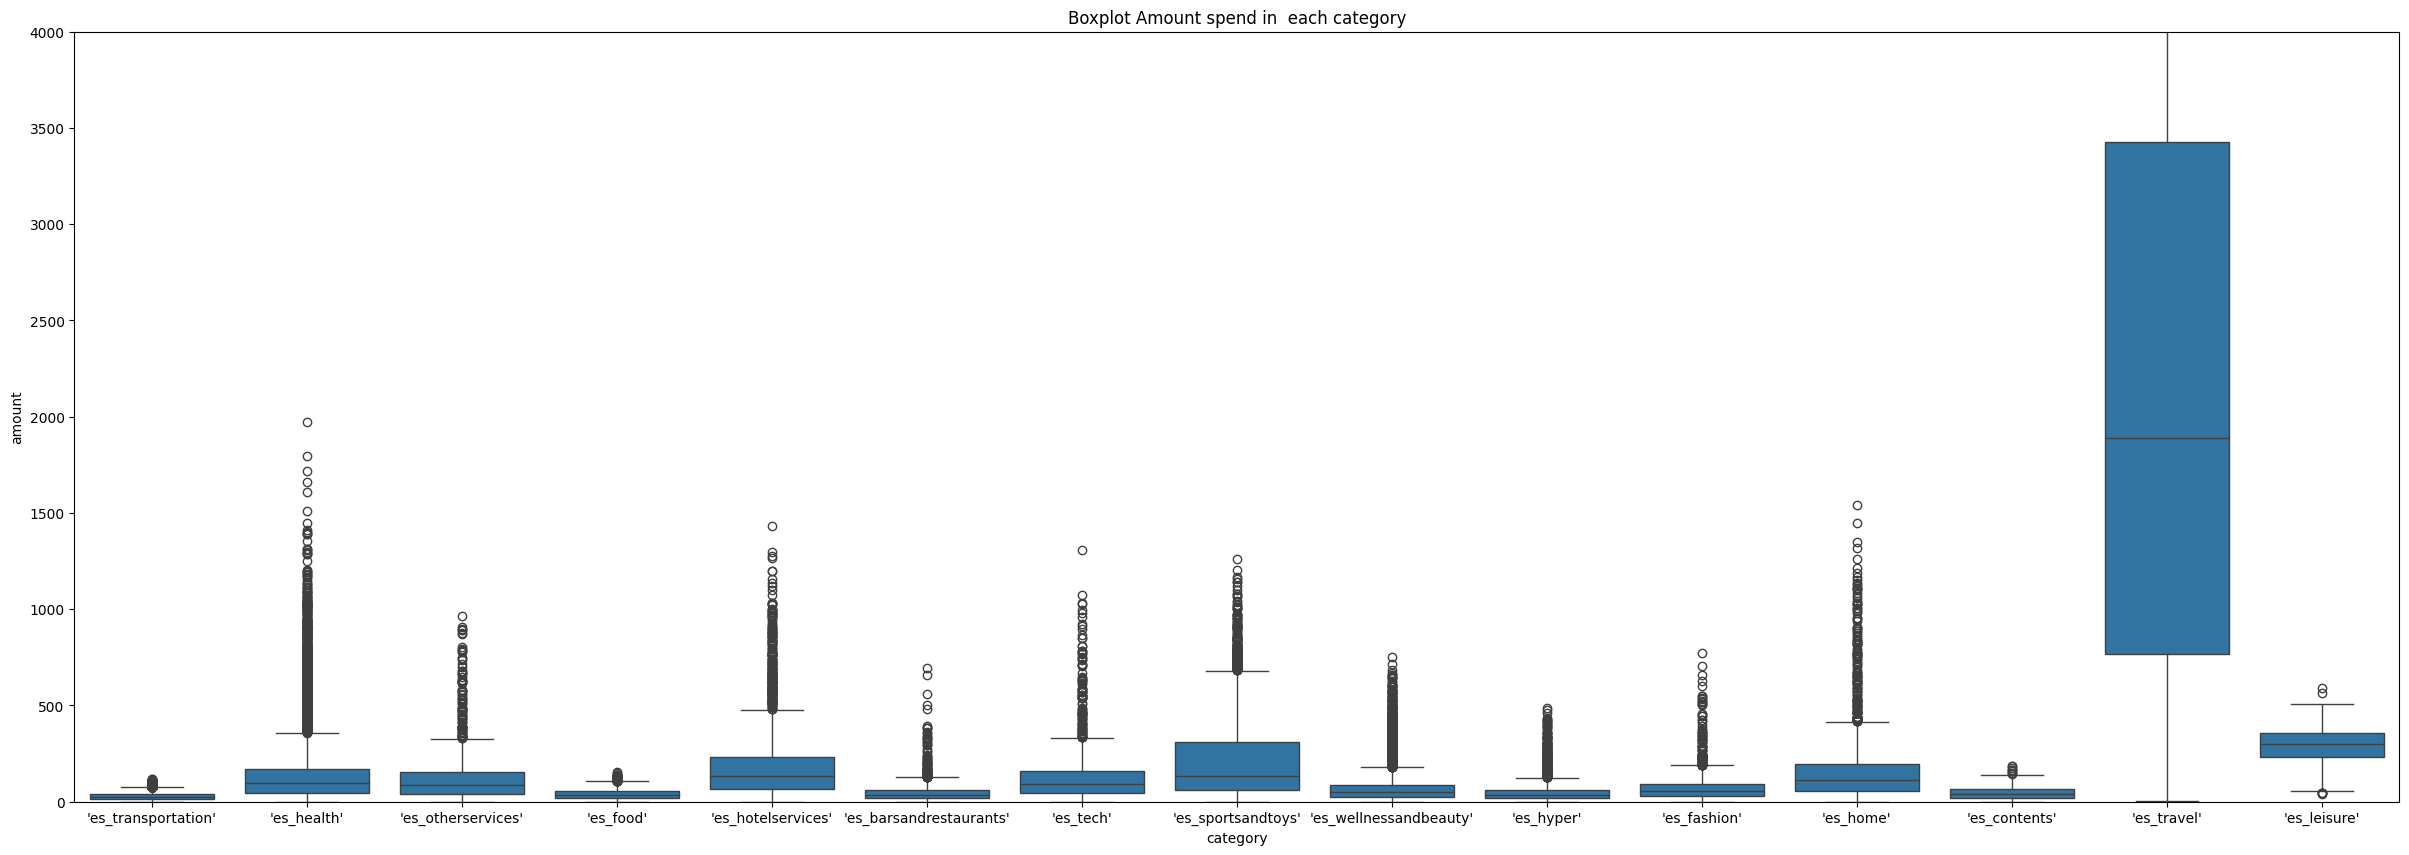

In [8]:


# Plot histograms of the amounts in fraud and non-fraud data 
plt.figure(figsize=(30,10))
sb.boxplot(x=data.category,y=data.amount)
plt.title("Boxplot Amount spend in  each category")
plt.ylim(0,4000)
plt.show()

In the histogram below, we can see the fradulent transactions are less in count but more in amount.

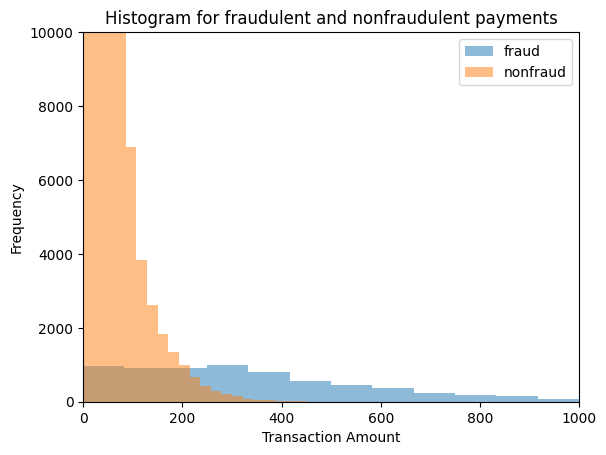

In [9]:

# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud', bins=100)
plt.hist(df_nfraud.amount, alpha=0.5, label='nonfraud', bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.ylim(0, 10000)
plt.xlim(0, 1000)
plt.legend()
plt.show()

In the below table you can see in the Age category of "0", the probability of fraud is more. Maybe the fraudsters thinking its less consequences if they show their age under 18.

In [10]:

# Calculate the mean fraud percentage
fraud_percent = data.groupby('age')['fraud'].mean() * 100

# Count the number of frauds and non-frauds
fraud_counts = data[data['fraud'] == 1].groupby('age').size().reset_index(name='Number of Frauds')
non_fraud_counts = data[data['fraud'] == 0].groupby('age').size().reset_index(name='Number of Non-Frauds')

# Merge the counts with the fraud percentage
result = fraud_percent.reset_index().rename(columns={'age': 'Age', 'fraud': 'Fraud Percent'})
fraud_counts = fraud_counts.rename(columns={'age': 'Age'})
non_fraud_counts = non_fraud_counts.rename(columns={'age': 'Age'})

result = result.merge(fraud_counts, on='Age', how='left').merge(non_fraud_counts, on='Age', how='left')

# Sort by Fraud Percent
result = result.sort_values(by='Fraud Percent')

print(result)

   Age  Fraud Percent  Number of Frauds  Number of Non-Frauds
7  'U'       0.594228                 7                  1171
6  '6'       0.974826               261                 26513
5  '5'       1.095112               686                 61956
1  '1'       1.185254               689                 57442
3  '3'       1.192815              1755                145376
2  '2'       1.251401              2344                184966
4  '4'       1.293281              1410                107615
0  '0'       1.957586                48                  2404


# Data Preprocessing
In this part we will preprocess and prepare the data for the training.

In [13]:
print("Unique values of zipMerchant : ",data.zipMerchant.nunique())
print("Unique values of zipCodeOri : ",data.zipcodeOri.nunique())
# dropping zipcodeori and zipMerchant 
reduced_data = data.drop(['zipMerchant','zipcodeOri'],axis=1)

Unique values of zipMerchant :  1
Unique values of zipCodeOri :  1


columns after reducing

In [14]:
print(reduced_data.columns)

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')



To convert categorical features into numerical values, it's often preferable to use dummy variables since categorical values don't have an inherent order (e.g., customer1 isn't greater than customer2).
 However, with over 500,000 customers and merchants, creating dummy variables would result in a feature set of size (10^5), making the training process extremely slow. Below is the code to transform categorical features into numerical values.

In [15]:

# Convert object columns to categorical type for easier transformation
categorical_columns = reduced_data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    reduced_data[column] = reduced_data[column].astype('category')

# Convert categorical values to numeric codes
reduced_data[categorical_columns] = reduced_data[categorical_columns].apply(lambda x: x.cat.codes)
reduced_data.head(5)


,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


In [24]:
X = reduced_data.drop(['fraud'],axis=1)
y = reduced_data['fraud']
print(X.head(5),"\n")
print(y.head(5))
y[y==1].count()


   step  customer  age  gender  merchant  category  amount
0     0       210    4       2        30        12    4.55
1     0      2753    2       2        30        12   39.68
2     0      2285    4       1        18        12   26.89
3     0      1650    3       2        30        12   17.25
4     0      3585    5       2        30        12   35.72 

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


7200

# Oversampling with SMOTE

for balancing the dataset, SMOTE(Synthetic Minority Oversampling Technique) is used. In the result we can see the count of both classes(fraud and nonFraud) are the same.

In [31]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)
print(y_res['fraud'].value_counts())

fraud
0    587443
1    587443
Name: count, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)
